# А/B-тест алгоритма мэтчинга

<div style="border: 2px solid #17a2b8; padding: 10px; border-radius: 10px; 
            box-shadow: 3px 3px 10px rgba(0,0,0,0.1);">
<b> Для начала подгрузим все необходимые библиотеки
</div>

In [19]:
import pandas as pd
import numpy as np
import scipy.stats as st
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
# Прочитаем данные 
data = pd.read_csv('dating_data.csv')

In [21]:
data.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [22]:
# Группа 0 - использовала старый алгоритм
# Группа 1 - использовала новый алгоритм

<div style="border: 2px solid #17a2b8; padding: 10px; border-radius: 10px; 
            box-shadow: 3px 3px 10px rgba(0,0,0,0.1);">
<b> Найдем, чему равна средняя доля мэтчей на пользователя в каждой группе
</div>

In [23]:
# Подсчитываем количество действий пользователя (лайков/дизлайков)
# Суммируем количество взаимных лайков

aggregate = (data.groupby(['user_id_1', 'group'], as_index=False)
      .agg({'user_id_2': 'count',  
            'is_match': 'sum'})
      .rename(columns={'user_id_1': 'user_id',
                       'user_id_2': 'actions',
                       'is_match': 'matchs_count'}))

In [25]:
# Рассчитываем долю совпадений среди действий пользователя
aggregate['matchs_share'] = round(aggregate['matchs_count'] / aggregate['actions'], 2)

In [26]:
aggregate.head()

,user_id,group,actions,matchs_count,matchs_share
0,1,1,24,11,0.46
1,2,1,16,7,0.44
2,3,1,16,5,0.31
3,4,0,9,2,0.22
4,5,1,22,13,0.59


In [7]:
aggregate.query('group == 0').matchs_share.describe()

count    501.000000
mean       0.193593
std        0.134368
min        0.000000
25%        0.100000
50%        0.180000
75%        0.270000
max        0.670000
Name: matchs_share, dtype: float64

> Средняя доля мэтчей в **группе 0 = 19%**

In [29]:
aggregate.query('group == 1').matchs_share.describe()

count    499.000000
mean       0.402405
std        0.114209
min        0.000000
25%        0.330000
50%        0.400000
75%        0.480000
max        0.720000
Name: matchs_share, dtype: float64

> Средняя доля мэтчей в **группе 1 = 40%**

<div style="border: 2px solid #17a2b8; padding: 10px; border-radius: 10px; 
            box-shadow: 3px 3px 10px rgba(0,0,0,0.1);">
<b> Проверим гипотезу о том, что средняя доля мэтчей в 0 группе (старый алгоритм) не отличается от доли мэтчей в 1 группе
</div>

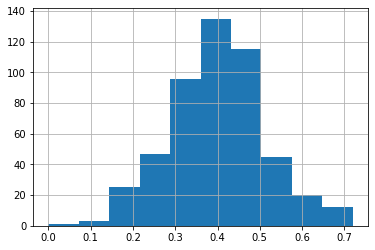

In [32]:
# Посмотрим, как распределены данные 
aggregate.query("group == 1").matchs_share.hist()

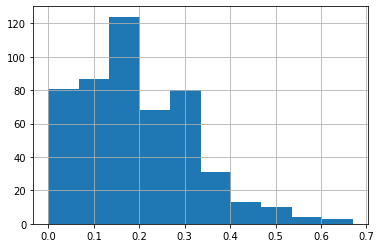

In [33]:
aggregate.query("group == 0").matchs_share.hist()

In [34]:
# Проверяем сандартное отклонение 
aggregate.groupby("group").matchs_share.std()

group
0    0.134368
1    0.114209
Name: matchs_share, dtype: float64

In [35]:
# Смотрим нормальность по Шапиро
pg.normality(data=aggregate, dv="matchs_share", group="group")

,W,pval,normal
1,0.995512,1.621243e-01,True
0,0.956623,5.656123e-11,False


In [36]:
# Применим t-критерий Уэлча, так как обе переменные — количественные
st.ttest_ind(aggregate.query('group == 0').matchs_share,
             aggregate.query('group == 1').matchs_share,
             equal_var=False)

Ttest_indResult(statistic=-26.481431782585016, pvalue=7.890669157069948e-117)

> **Отклоняем нулевую гиоптезу, поскольку pvalue < 0,05**

<div style="border: 2px solid #17a2b8; padding: 10px; border-radius: 10px; 
            box-shadow: 3px 3px 10px rgba(0,0,0,0.1);">
<b> Проверим, есть ли различия в среднем количестве действий на пользователя в двух полученных группах. 
</div>

Проверьте, есть ли различия в среднем количестве действий на пользователя в двух полученных группах. Чему равно значение среднего количества действий в 0 группе?

In [38]:
# Найдем значения среднего количества действий в группах 
aggregate.query('group == 0').actions.describe()

count    501.000000
mean       9.564870
std        3.056515
min        1.000000
25%        8.000000
50%        9.000000
75%       12.000000
max       20.000000
Name: actions, dtype: float64

> Среднее количество действий в **группе 0 = 9.56**

In [38]:
aggregate.query('group == 1').actions.describe()

count    499.000000
mean      19.482966
std        2.991489
min       11.000000
25%       18.000000
50%       20.000000
75%       22.000000
max       29.000000
Name: actions, dtype: float64

> Среднее количество действий в **группе 1 = 19.48**

In [39]:
# Для проверки гипотезы используем t-критерий Стьюдента, поскольку переменные обе количественные
st.ttest_ind(a = aggregate.query("group == 0").actions, 
             b = aggregate.query("group == 1").actions, 
             equal_var=True)

Ttest_indResult(statistic=-51.85383774946492, pvalue=1.8942877064043142e-285)

> **Отклоняем нулевую гиоптезу, поскольку pvalue < 0,05**

Результаты A/B-теста показали, что новая система **улучшила долю мэтчей и активность клиентов в продукте.**
Поэтому рекомендуется **включать** новую систему поиска анкет на всех пользователей.